# TPE INFO 365 : Système de prévision des ventes
---

## 1. Définition du problème

prédire les ventes quotidiennes du super marché supermarket.

---

## 2. Collecte, Préparation et nettoyage des données

- Détection et gestion des valeurs manquantes
- Validation des types de données
- Création de séries multivariées (par branche, par categories de produits)
- Détecter et marquer les outliers

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

history_df = pd.read_csv("supermarket_sales.csv")

print("="*80)
print("ÉTAPE 1: INSPECTION ET NETTOYAGE DES DONNÉES")
print("="*80)

# 1. Exploration initiale
print("\n1. Aperçu du dataset:")
print(f"   Forme: {history_df.shape}")
print(f"   Colonnes: {history_df.columns.tolist()}")
print(f"\n   Types de données:\n{history_df.dtypes}")

# 2. Vérifier les valeurs manquantes
print(f"\n2. Valeurs manquantes:\n{history_df.isnull().sum()}")

# 3. Statistiques descriptives
print(f"\n3. Statistiques descriptives des colonnes numériques:")
print(history_df[['Unit price', 'Quantity', 'Sales', 'Rating']].describe())

# 4. Convertir Date en datetime et valider
history_df['Date'] = pd.to_datetime(history_df['Date'], dayfirst=False, errors='coerce')
history_df['Time'] = pd.to_datetime(history_df['Time'], format='%I:%M:%S %p', errors='coerce')

print(f"\n4. Plage temporelle:")
print(f"   Dates manquantes: {history_df['Date'].isnull().sum()}")
print(f"   Heures manquantes: {history_df['Time'].isnull().sum()}")
print(f"   Date min: {history_df['Date'].min()}")
print(f"   Date max: {history_df['Date'].max()}")
print(f"   Durée totale: {(history_df['Date'].max() - history_df['Date'].min()).days} jours")

# 5. Vérifier les catégories
print(f"\n5. Catégories présentes:")
print(f"   Branches: {history_df['Branch'].unique().tolist()}")
print(f"   Lignes de produits: {history_df['Product line'].unique().tolist()}")
print(f"   Types de clients: {history_df['Customer type'].unique().tolist()}")
print(f"   Genres: {history_df['Gender'].unique().tolist()}")
print(f"   Moyens de paiement: {history_df['Payment'].unique().tolist()}")

# 6. Trier par date
history_df = history_df.sort_values('Date', na_position='first', ascending=False)
history_df.reset_index(drop=True, inplace=True)

# 7. Détection basique des outliers (z-score)
def detect_outliers(data, column, threshold=3):
    z_scores = np.abs((data[column] - data[column].mean()) / data[column].std())
    return z_scores > threshold

outliers_sales = detect_outliers(history_df, 'Sales', threshold=3)
print(f"\n6. Outliers détectés (z-score > 3): {outliers_sales.sum()} sur {len(history_df)} lignes")

print(f"\n✓ Données chargées et validées")

ÉTAPE 1: INSPECTION ET NETTOYAGE DES DONNÉES

1. Aperçu du dataset:
   Forme: (1000, 17)
   Colonnes: ['Invoice ID', 'Branch', 'City', 'Customer type', 'Gender', 'Product line', 'Unit price', 'Quantity', 'Tax 5%', 'Sales', 'Date', 'Time', 'Payment', 'cogs', 'gross margin percentage', 'gross income', 'Rating']

   Types de données:
Invoice ID                  object
Branch                      object
City                        object
Customer type               object
Gender                      object
Product line                object
Unit price                 float64
Quantity                     int64
Tax 5%                     float64
Sales                      float64
Date                        object
Time                        object
Payment                     object
cogs                       float64
gross margin percentage    float64
gross income               float64
Rating                     float64
dtype: object

2. Valeurs manquantes:
Invoice ID                 0
Branc

In [2]:
print("\n7. Création de la série temporelle univariée:")

daily_sales = history_df.groupby('Date')['Sales'].sum().reset_index()
daily_sales = daily_sales.rename(columns={'Date': 'ds', 'Sales': 'y'})

# Vérifier fréquence
daily_sales = daily_sales.set_index('ds').asfreq('D').fillna(0).reset_index()
print(f"   Vente minimale: {daily_sales['y'].min()}")
print(f"   Vente maximale: {daily_sales['y'].max()}")
print(f"   Jours avec données: {(daily_sales['y'] > 0).sum()}")
print(f"   Jours manquants (remplis 0): {(daily_sales['y'] == 0).sum()}")
print(f"   Forme finale: {daily_sales.shape}")

# Créer séries MULTIVARIÉES par BRANCHE
print("\n8. Création de la série temporelle multivariées par branche:")
daily_by_branch = history_df.groupby(['Date', 'Branch'])['Sales'].sum().reset_index()
daily_by_branch = daily_by_branch.rename(columns={'Date': 'ds', 'Sales': 'y'})
daily_by_branch_pivot = daily_by_branch.pivot(index='ds', columns='Branch', values='y').fillna(0).reset_index()

print(f"   Branches: {[col for col in daily_by_branch_pivot.columns if col != 'ds']}")
print(f"   Forme: {daily_by_branch_pivot.shape}")

# Créer séries MULTIVARIÉES par LIGNE DE PRODUIT
print("\n9. Création de la série temporelle multivariées par ligne de produit:")
daily_by_product = history_df.groupby(['Date', 'Product line'])['Sales'].sum().reset_index()
daily_by_product = daily_by_product.rename(columns={'Date': 'ds', 'Sales': 'y'})
daily_by_product_pivot = daily_by_product.pivot(index='ds', columns='Product line', values='y').fillna(0).reset_index()

print(f"   Lignes de produits: {[col for col in daily_by_product_pivot.columns if col != 'ds']}")
print(f"   Forme: {daily_by_product_pivot.shape}")

print(f"✓ Series temporelles créées et prêtes pour l'analyse")



7. Création de la série temporelle univariée:
   Vente minimale: 934.2375
   Vente maximale: 7474.0470000000005
   Jours avec données: 89
   Jours manquants (remplis 0): 0
   Forme finale: (89, 2)

8. Création de la série temporelle multivariées par branche:
   Branches: ['Alex', 'Cairo', 'Giza']
   Forme: (89, 4)

9. Création de la série temporelle multivariées par ligne de produit:
   Lignes de produits: ['Electronic accessories', 'Fashion accessories', 'Food and beverages', 'Health and beauty', 'Home and lifestyle', 'Sports and travel']
   Forme: (89, 7)
✓ Series temporelles créées et prêtes pour l'analyse


---

## 3. Analyse Exploratoire des données (EDA)

- Décomposition STL pour trend/saisonnalité
- ACF/PACF pour identifier ordres ARIMA
- Heatmaps et corrélations
- Analyse par segment (branche, produit)
- Détection patterns week-end/weekday


ÉTAPE 2: ANALYSE EXPLORATOIRE

 1. Série temporelle univariée

 1. Série temporelle univariée


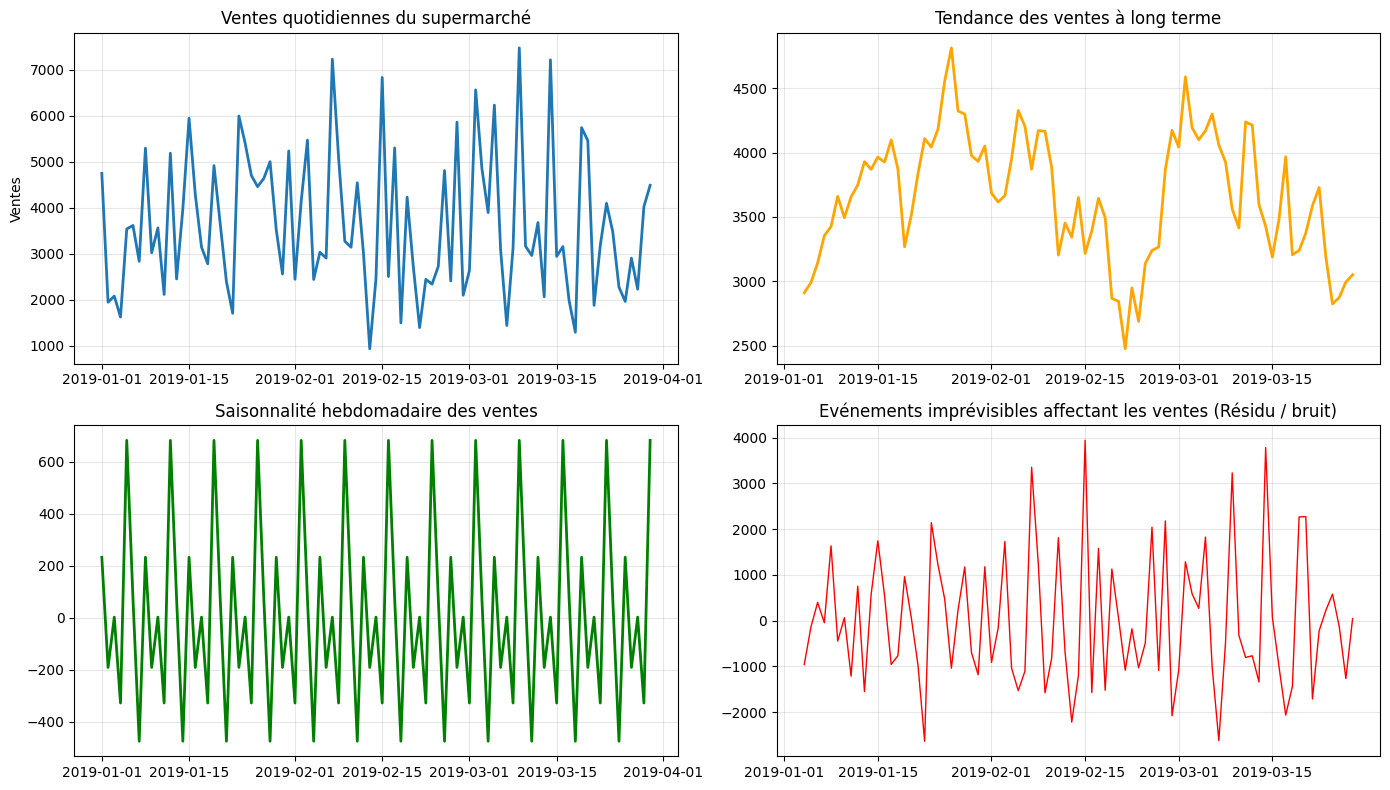

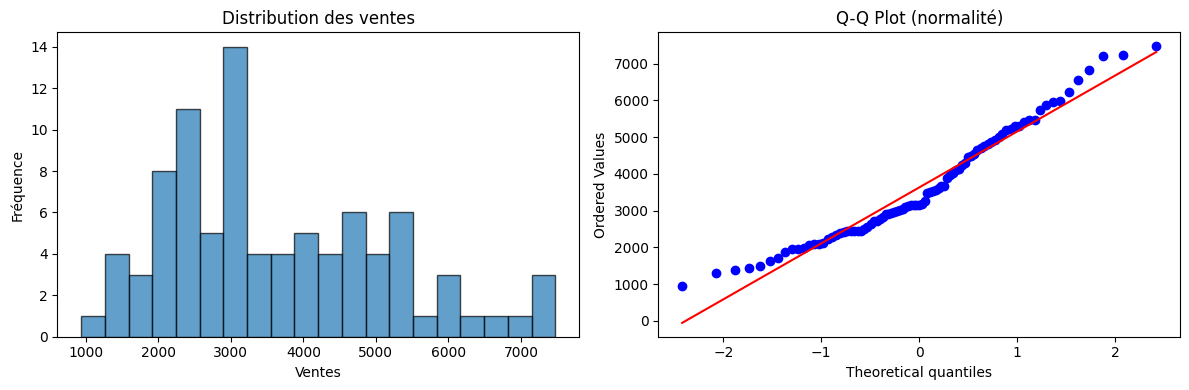

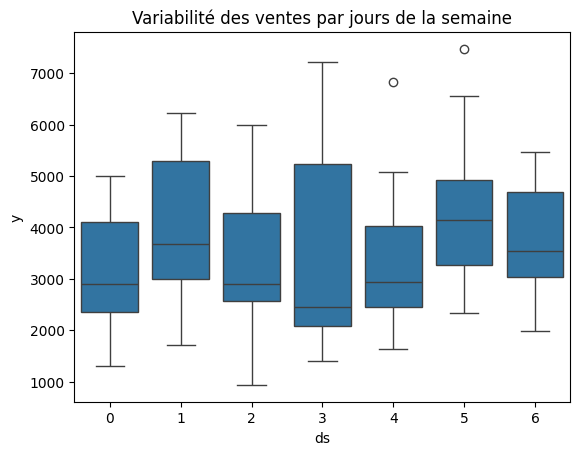

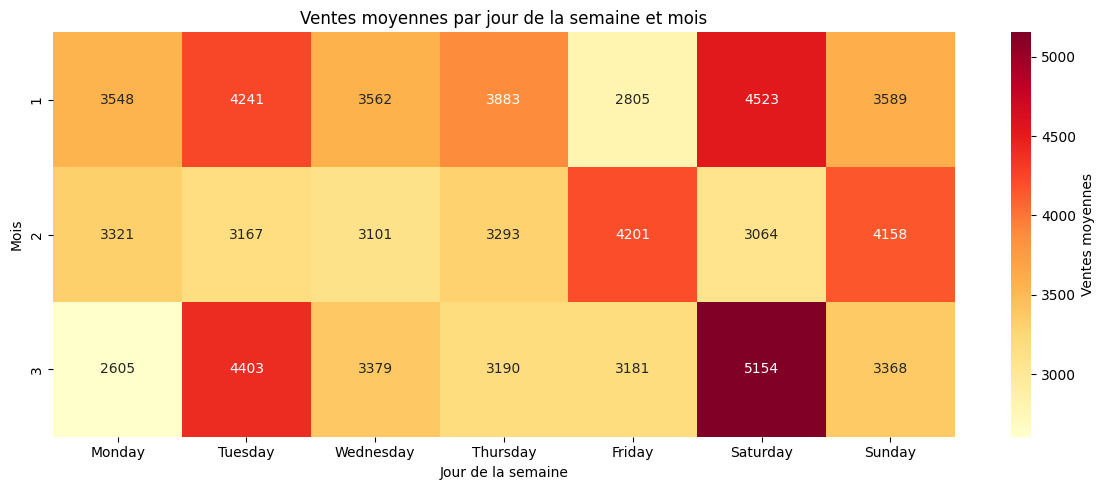

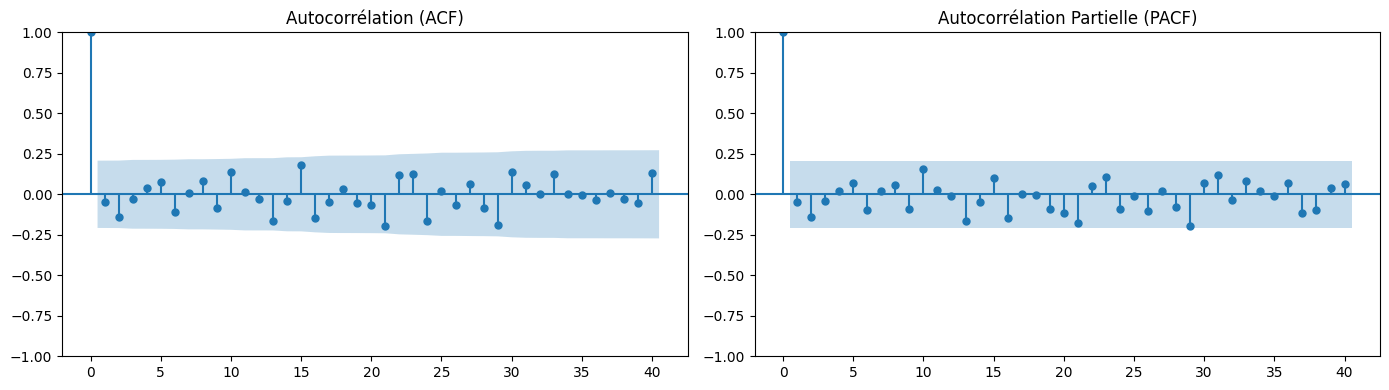


 2. Série temporelle multi-variée


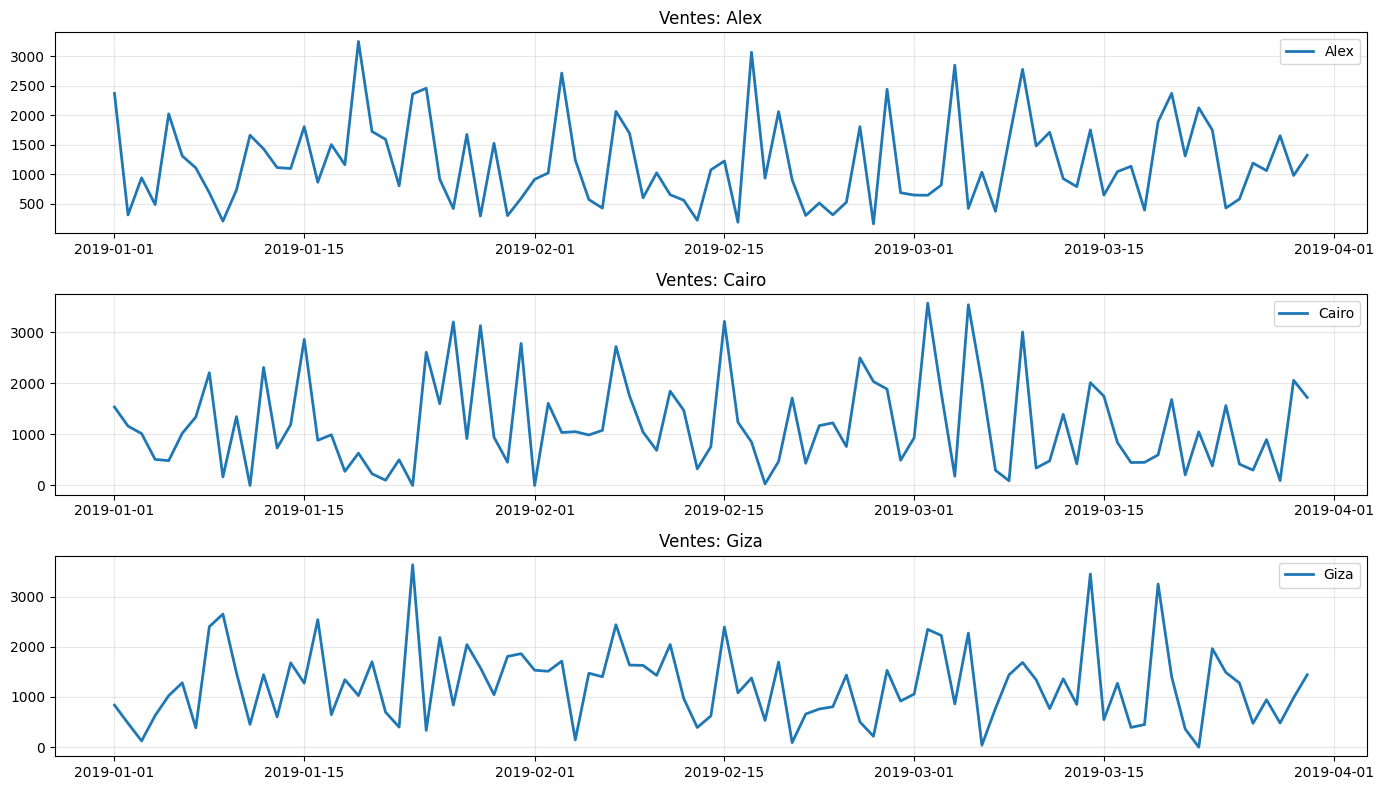


✓ EDA complétée


In [3]:
print("\n" + "="*80)
print("ÉTAPE 2: ANALYSE EXPLORATOIRE")
print("="*80)

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy import stats

print("\n 1. Série temporelle univariée")
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Courbe des ventes dans le temps.
# Objectif : voir la tendance générale et repérer les pics.
axes[0, 0].plot(daily_sales['ds'], daily_sales['y'], linewidth=2)
axes[0, 0].set_title('Ventes quotidiennes du supermarché')
axes[0, 0].set_ylabel('Ventes')
axes[0, 0].grid(True, alpha=0.3)

# Décomposition de la série temporelle (trend + saison + résidu)
# Objectif : voir la tendance, saisonnalité hebdomadaire.
try:
    """
    La décomposition (seasonal decomposition) sert à séparer la série temporelle en trois composants :
    
    - Trend (Tendance): Tendance des ventes a long terme (croissante, décroissante, stable).
    - Seasonal (Saisonnalité) : Comportements qui se répètent periodiquement (chaque semaine ou mois).
    - Residual (Résidu / bruit) : Evénements imprévisibles affectant les ventes.
    
    L’objectif est de mieux comprendre le comportement de la série afin de déterminer
    quel modèle choisir (ARIMA, Prophet, LSTM, XGBoost…).
    """
    decomposition_df = daily_sales[['ds', 'y']]
    decomposition_df.set_index('ds', inplace=True)
    decomposition = seasonal_decompose(decomposition_df['y'], model='additive', period=7)
    
    axes[0, 1].plot(decomposition.trend, color='orange', linewidth=2)
    axes[0, 1].set_title('Tendance des ventes à long terme')
    axes[0, 1].grid(True, alpha=0.3)
    
    axes[1, 0].plot(decomposition.seasonal, color='green', linewidth=2)
    axes[1, 0].set_title('Saisonnalité hebdomadaire des ventes')
    axes[1, 0].grid(True, alpha=0.3)
    
    axes[1, 1].plot(decomposition.resid, color='red', linewidth=1)
    axes[1, 1].set_title('Evénements imprévisibles affectant les ventes (Résidu / bruit)')
    axes[1, 1].grid(True, alpha=0.3)
except Exception as e:
    print(f"⚠ Décomposition STL échouée: {e}")

plt.tight_layout()
plt.show()

# Distribution des ventes (vérifier normalité)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(daily_sales['y'], bins=20, edgecolor='black', alpha=0.7)
axes[0].set_title('Distribution des ventes')
axes[0].set_xlabel('Ventes')
axes[0].set_ylabel('Fréquence')

stats.probplot(daily_sales['y'], dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot (normalité)')
plt.tight_layout()
plt.show()

# Variabilité des ventes par jours de la semaine"
sns.boxplot(x=daily_sales['ds'].dt.day_of_week, y=daily_sales['y'])
plt.title("Variabilité des ventes par jours de la semaine")
plt.show()

# Heatmap: ventes par jour de semaine et semaine du mois
heatmap_df = daily_sales.copy()
heatmap_df['dow'] = heatmap_df['ds'].dt.day_name()
heatmap_df['week'] = heatmap_df['ds'].dt.isocalendar().week
heatmap_df['month'] = heatmap_df['ds'].dt.month

dow_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_data = heatmap_df.groupby(['month', 'dow'])['y'].mean().unstack(fill_value=0)
heatmap_data = heatmap_data[dow_order]

plt.figure(figsize=(12, 5))
sns.heatmap(heatmap_data, annot=True, fmt='.0f', cmap='YlOrRd', cbar_kws={'label': 'Ventes moyennes'})
plt.title('Ventes moyennes par jour de la semaine et mois')
plt.xlabel('Jour de la semaine')
plt.ylabel('Mois')
plt.tight_layout()
plt.show()

# Auto-corrélation et partielle (ACF/PACF) pour identification ARIMA
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
plot_acf(daily_sales['y'].dropna(), lags=40, ax=axes[0])
axes[0].set_title('Autocorrélation (ACF)')
plot_pacf(daily_sales['y'].dropna(), lags=40, ax=axes[1], method='ywm')
axes[1].set_title('Autocorrélation Partielle (PACF)')
plt.tight_layout()
plt.show()

print("\n 2. Série temporelle multi-variée")

# Comparaison multivariée par branche
fig, axes = plt.subplots(3, 1, figsize=(14, 8))
branches = [col for col in daily_by_branch_pivot.columns if col != 'ds']
for idx, branch in enumerate(branches):
    axes[idx].plot(daily_by_branch_pivot['ds'], daily_by_branch_pivot[branch], label=branch, linewidth=2)
    axes[idx].set_title(f'Ventes: {branch}')
    axes[idx].grid(True, alpha=0.3)
    axes[idx].legend()
plt.tight_layout()
plt.show()

print("\n✓ EDA complétée")


---
## 4. Ingénierie Complète des Features (Univarié + Multivarié)

- Lags et fenêtres roulantes
- Features temporelles riches (jour/mois/semaine/trimestre)
- Features saisonnières encodées
- Encodage des catégories
- Pas de leakage futur

In [4]:
print("\n" + "="*80)
print("ÉTAPE 3: INGÉNIERIE COMPLÈTE DES FEATURES")
print("="*80)

from sklearn.preprocessing import StandardScaler, LabelEncoder

# 1. Aggrégation quotidienne
print("\n1. Créer variables exogènes agrégées:")
exog_features = history_df.groupby('Date').agg(
    n_transactions=('Invoice ID', 'nunique'),  # Nombre de transactions
    avg_price=('Unit price', 'mean'),          # Prix moyen
    qty_sum=('Quantity', 'sum'),               # Quantité totale
    avg_rating=('Rating', 'mean'),             # Note moyenne
    prop_female=('Gender', lambda x: (x == 'Female').sum() / len(x)),
    prop_member=('Customer type', lambda x: (x == 'Member').sum() / len(x)),
    prop_cash=('Payment', lambda x: (x == 'Cash').sum() / len(x)),
    prop_ewallet=('Payment', lambda x: (x == 'Ewallet').sum() / len(x)),
    prop_credit=('Payment', lambda x: (x == 'Credit card').sum() / len(x))
).reset_index().rename(columns={'Date': 'ds'})

daily_sales = daily_sales.merge(exog_features, on='ds', how='left', suffixes=('', '_drop'))
daily_sales = daily_sales[[col for col in daily_sales.columns if not col.endswith('_drop')]]
print(f"   Variables exogènes ajoutées: {exog_features.columns[1:].tolist()}")

# 2. Features TEMPORELLES
print("\n2. Création des features temporelles:")
daily_sales['day_of_week'] = daily_sales['ds'].dt.dayofweek        # 0=Lundi, 6=Dimanche
daily_sales['day_of_month'] = daily_sales['ds'].dt.day
daily_sales['week_of_year'] = daily_sales['ds'].dt.isocalendar().week
daily_sales['month'] = daily_sales['ds'].dt.month
daily_sales['quarter'] = daily_sales['ds'].dt.quarter
daily_sales['is_weekend'] = (daily_sales['day_of_week'] >= 5).astype(int)
daily_sales['is_month_start'] = (daily_sales['day_of_month'] <= 3).astype(int)
daily_sales['is_month_end'] = (daily_sales['day_of_month'] >= 28).astype(int)
daily_sales['day_sin'] = np.sin(2 * np.pi * daily_sales['day_of_week'] / 7)
daily_sales['day_cos'] = np.cos(2 * np.pi * daily_sales['day_of_week'] / 7)
daily_sales['month_sin'] = np.sin(2 * np.pi * daily_sales['month'] / 12)
daily_sales['month_cos'] = np.cos(2 * np.pi * daily_sales['month'] / 12)

temporal_cols = [col for col in daily_sales.columns if col.startswith(('day_', 'week_', 'month', 'quarter', 'is_'))]
print(f"   Features créées: {len(temporal_cols)}")

# 3. Features LAG
print("\n3. Création des features LAG:")
lag_days = [1, 7, 14, 28] # Capture des tendances passées (jours j-1, j-7, j-14 et j-28)
for lag in lag_days:
    daily_sales[f'lag_{lag}'] = daily_sales['y'].shift(lag) # Ventes du jour j-lag
    daily_sales[f'lag_{lag}_qty'] = daily_sales['qty_sum'].shift(lag) # Quantité totale du jour j-lag

# 4. Features ROLLING (fenêtres glissantes)
print("\n4. Création des features ROLLING:")
rolling_windows = [7, 14, 30] # Statistiques sur fenêtres de 7, 14 et 30 jours
for window in rolling_windows:
    daily_sales[f'rolling_mean_{window}'] = daily_sales['y'].rolling(window=window, min_periods=1).mean()
    daily_sales[f'rolling_std_{window}'] = daily_sales['y'].rolling(window=window, min_periods=1).std().fillna(0)
    daily_sales[f'rolling_max_{window}'] = daily_sales['y'].rolling(window=window, min_periods=1).max()
    daily_sales[f'rolling_min_{window}'] = daily_sales['y'].rolling(window=window, min_periods=1).min()

# 5. Features de CROISSANCE (différences)
print("\n5. Création des features de croissance:")
growth_features = [1, 7] # Différence de ventes
for lag in growth_features:
    daily_sales[f'diff_{lag}'] = daily_sales['y'].diff(lag) # croissance quotidienne et hebdomadaire
    daily_sales[f'pct_change_{lag}'] = daily_sales['y'].pct_change(lag) # % d’évolution quotidien et hebdomadaire

# 6. Features SAISONNIERS MOYENS (moyenne par jour de semaine, etc.)
print("\n6. Création des features saisonnières (moyennes historiques):")
seasonal_dow = daily_sales.groupby('day_of_week')['y'].transform('mean').fillna(0)
seasonal_month = daily_sales.groupby('month')['y'].transform('mean').fillna(0)
daily_sales['seasonal_dow_mean'] = seasonal_dow # Moyenne des ventes par jour de la semaine
daily_sales['seasonal_month_mean'] = seasonal_month # Moyenne des ventes par mois

# 7. Gestion des NaN (Essentiel à cause des lags et rolling windows.)
print("\n7. Gestion des valeurs manquantes:")
print(f"   NaN avant: {daily_sales.isnull().sum().sum()}")
daily_sales = daily_sales.fillna(method='bfill', limit=50).fillna(0)
print(f"   NaN après: {daily_sales.isnull().sum().sum()}")

# Supprimer les premières lignes si trop de NaN (lags)
print(f"   Forme avant suppresion NaN: {daily_sales.shape}")
daily_sales = daily_sales.dropna(subset=['y'], how='any')
print(f"   Forme après suppresion NaN: {daily_sales.shape}")

# 8. Résumé features
feature_cols = [col for col in daily_sales.columns if col not in ['ds', 'y']]
print(f"\n8. Résumé des features créées:")
print(f"   Total: {len(feature_cols)} features")
print(f"   Temporelles: {len(temporal_cols)}")
print(f"   Lags: {len([c for c in feature_cols if 'lag' in c])}")
print(f"   Rolling: {len([c for c in feature_cols if 'rolling' in c])}")
print(f"   Autres: {len([c for c in feature_cols if c not in temporal_cols and 'lag' not in c and 'rolling' not in c])}")

print("\n✓ Feature engineering complétée")
print(f"\nDataFrame prêt pour modélisation:")
print(daily_sales.head(10))



ÉTAPE 3: INGÉNIERIE COMPLÈTE DES FEATURES

1. Créer variables exogènes agrégées:
   Variables exogènes ajoutées: ['n_transactions', 'avg_price', 'qty_sum', 'avg_rating', 'prop_female', 'prop_member', 'prop_cash', 'prop_ewallet', 'prop_credit']

2. Création des features temporelles:
   Features créées: 12

3. Création des features LAG:

4. Création des features ROLLING:

5. Création des features de croissance:

6. Création des features saisonnières (moyennes historiques):

7. Gestion des valeurs manquantes:
   NaN avant: 116
   NaN après: 0
   Forme avant suppresion NaN: (89, 49)
   Forme après suppresion NaN: (89, 49)

8. Résumé des features créées:
   Total: 47 features
   Temporelles: 12
   Lags: 8
   Rolling: 12
   Autres: 15

✓ Feature engineering complétée

DataFrame prêt pour modélisation:
          ds          y  n_transactions  avg_price  qty_sum  avg_rating  \
0 2019-01-01  4745.1810              12  54.995833       81    6.583333   
1 2019-01-02  1945.5030               8  4

---
## 5. Validation Temporelle (TimeSeriesSplit) et Métriques Robustes

- TimeSeriesSplit
- Métriques complètes : MAE, RMSE, MAPE, sMAPE, MASE
- Evaluation modeles Naïf

In [5]:
print("\n" + "="*80)
print("ÉTAPE 4: VALIDATION TEMPORELLE ET MÉTRIQUES")
print("="*80)

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# 1. Préparer les données pour ML
print("\n1. Préparation données ML:")
X = daily_sales[feature_cols].values
Y = daily_sales['y'].values

print(f"   X shape: {X.shape}")
print(f"   Y shape: {Y.shape}")
print(f"   Features: {len(feature_cols)}")

# 2. TimeSeriesSplit (TimeSeriesSplit découpe les données en respectant le temps)
print("\n2. Configuration TimeSeriesSplit:")
n_splits = 5 # données divisées en 5 parties.
gap = 0      # Pas de gap (période d'exclusion) entre train et test.
tscv = TimeSeriesSplit(n_splits=n_splits, gap=gap)

train_indices_list = []
test_indices_list = []

for train_idx, test_idx in tscv.split(X):
    train_indices_list.append(train_idx)
    test_indices_list.append(test_idx)
    print(f"   Fold: train {len(train_idx)} samples, test {len(test_idx)} samples")

# Utiliser le dernier split pour nos modèles
train_idx, test_idx = train_indices_list[-1], test_indices_list[-1]
X_train, X_test = X[train_idx], X[test_idx]
Y_train, Y_test = Y[train_idx], Y[test_idx]

print(f"\n   Split final utilisé:")
print(f"   - Train: {len(train_idx)} samples ({len(train_idx)/len(Y)*100:.1f}%)")
print(f"   - Test: {len(test_idx)} samples ({len(test_idx)/len(Y)*100:.1f}%)")

# Separer le Dataset en train et test
df_train = daily_sales[daily_sales.index.isin(train_idx)].reset_index(drop=True)
df_test = daily_sales[daily_sales.index.isin(test_idx)].reset_index(drop=True)

# 3. Définir fonction d'évaluation complète
print("\n3. Métriques d'évaluation définies:")

def evaluate_model(y_true, y_pred, naive_mae, model_name, verbose=True):
    """Évaluation complète avec MAE, RMSE, MAPE, sMAPE, MASE"""
    
    # Erreur Absolue Moyenne / Mean Absolute Error (MAE = moyenne(|y_true - y_pred|))
    mae = mean_absolute_error(y_true, y_pred)
    
    # Erreur Quadratique Moyenne / Mean Squared Error (RMSE = sqrt(moyenne((y_true - y_pred)^2)))
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    # Erreur En Pourcentage Absolue Moyenne (MAPE = moyenne(|(y_true - y_pred) / y_true|) * 100)
    mape = np.mean(np.abs((y_true - y_pred) / np.where(y_true != 0, y_true, 1))) * 100
    
    # sMAPE / Symmetric MAPE (sMAPE = moyenne(2 * |y_pred - y_true| / (|y_true| + |y_pred|)) * 100)
    smape = np.mean(2.0 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-8)) * 100
    
    # MASE (Mean Absolute Scaled Error) - Mesure si le modèle est meilleur qu’un modèle naïf
    mase = mae / naive_mae
    
    metrics = {
        'MAE': mae, # Erreur moyenne réelle (idealement proche de 0)
        'RMSE': rmse, # Détecte grosses erreurs (idealement proche de 0 et de MAE)
        'MAPE': mape, # Erreur en pourcentage (idealement proche de 0%)
        'sMAPE': smape, # MAPE stable (idealement proche de 0%)
        'MASE': mase # Comparaison au modèle naïf (idealement < 1)
    }
    
    if verbose:
        print(f"\n{model_name}:")
        for metric_name, metric_value in metrics.items():
            if metric_name in ['MAE', 'RMSE', 'MASE']:
                print(f"   {metric_name}: {metric_value:.2f}")
            else:
                print(f"   {metric_name}: {metric_value:.2f}%")
    
    return metrics

# 4. Evaluer des baselines simples (modeles de référence)
print("\n4. Evaluer des baselines simples (modeles de référence):")

# Naïf t-1 : la prédiction = la valeur d’hier
naive_pred = np.roll(Y_test, 1) # decaler les valeurs de y_test d'un pas vers la droite
naive_pred[0] = Y_train[-1]   # la dernière valeur du train
print("\nBaseline Naïf (t-1):")
baseline_metrics = evaluate_model(Y_test, np.array(naive_pred), 1, "Naive")

# Naïf t-7 : la prédiction = le même jour de la semaine précédente
seasonal_pred = np.roll(Y_test, 7)
seasonal_pred[:7] = Y_train[-7:] 
print("\nBaseline Saisonnier (t-7):")
seasonal_metrics = evaluate_model(Y_test, seasonal_pred, 1, "Seasonal")

print("\n✓ Validation configurée et baselines calculées")



ÉTAPE 4: VALIDATION TEMPORELLE ET MÉTRIQUES

1. Préparation données ML:
   X shape: (89, 47)
   Y shape: (89,)
   Features: 47

2. Configuration TimeSeriesSplit:
   Fold: train 19 samples, test 14 samples
   Fold: train 33 samples, test 14 samples
   Fold: train 47 samples, test 14 samples
   Fold: train 61 samples, test 14 samples
   Fold: train 75 samples, test 14 samples

   Split final utilisé:
   - Train: 75 samples (84.3%)
   - Test: 14 samples (15.7%)

3. Métriques d'évaluation définies:

4. Evaluer des baselines simples (modeles de référence):

Baseline Naïf (t-1):

Naive:
   MAE: 1313.82
   RMSE: 1768.16
   MAPE: 46.66%
   sMAPE: 42.83%
   MASE: 1313.82

Baseline Saisonnier (t-7):

Seasonal:
   MAE: 1802.13
   RMSE: 2305.32
   MAPE: 72.45%
   sMAPE: 52.05%
   MASE: 1802.13

✓ Validation configurée et baselines calculées


---

## 6. Entraînement de Modèles: Univariés, Multivariés et ML

### Modèles implémentés:
1. **Prophet** (baseline univarié) - avec regressors exogènes
2. **SARIMAX** (multivarié exogène)
3. **LightGBM** (ML - lags + exogènes)
4. **LSTM** (Deep Learning - seq2seq)

In [6]:
print("\n" + "="*80)
print("ÉTAPE 5: ENTRAÎNEMENT DES MODÈLES")
print("="*80)

from prophet import Prophet
from statsmodels.tsa.statespace.sarimax import SARIMAX
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler

predictions_dict = {}

# ============================================================================
# MODÈLE 1 : PROPHET (avec régressions)
# ============================================================================
"""Modèle basé sur les composantes (trend + saisonnalité + régressions)

   y(t) = trend(t) + seasonality(t) + ∑​βi​Xi​(t)
   
   Prophet est bon si :

   ✔ tendance claire
   ✔ saisonnalité régulière
   ✔ long historique

   Il n’est pas bon si :

   ✘ série très courte (ce qui est le cas ici)
   ✘ données très volatiles
   ✘ présence de fortes promos / ruptures / anomalies
"""
try:
    print("\n=== PROPHET (robuste avec regressors) ===")
    exog_cols = ['n_transactions', 'avg_price', 'qty_sum', 'avg_rating']
    prophet_train = df_train[['ds', 'y'] + exog_cols]
    prophet_test = df_test[['ds'] + exog_cols]
    
    prophet_params = {
        'yearly_seasonality': True, 
        'weekly_seasonality': True,
        'daily_seasonality': False, 
        'interval_width': 0.95
    }
    m = Prophet(**prophet_params)
    
    # ajouter regressors (doit exister dans train & test)
    for reg in exog_cols:
        m.add_regressor(reg)
    
    m.fit(prophet_train)

    forecast = m.predict(prophet_test)
    prophet_pred = forecast['yhat'].values

    predictions_dict['Prophet'] = prophet_pred
    metrics_prophet = evaluate_model(Y_test, prophet_pred, baseline_metrics['MAE'], "PROPHET")
    
except Exception as e:
    print(f"   ⚠ Erreur Prophet: {e}")

# ============================================================================
# MODÈLE 2 : SARIMAX (multivarié avec exogènes)
# ============================================================================
"""Modèle classique ARIMA + variables exogènes

   ARIMA(p,d,q) + ARIMA(P,D,Q)7 + exogènes
   
   Ce modèle est très sensible :

   - aux données stationnaires
   - aux exogènes peu corrélées
   - au bruit
"""
try:
    print("\n=== SARIMAX (avec exogènes normalisés) ===")
    exog_train = df_train[exog_cols].values
    exog_test  = df_test[exog_cols].values
    
    # Standardiser les variables exogènes en soustrayant la moyenne et en divisant par l'écart-type.
    scaler = StandardScaler()
    exog_train_scaler = scaler.fit_transform(exog_train)
    exog_test_scaler  = scaler.transform(exog_test)

    sarimax_params = {
        'order': (1,1,1),             
        'seasonal_order': (1,1,1,7),
        'enforce_stationarity': False, 
        'enforce_invertibility': False
    }
    sarimax_model = SARIMAX(
        Y_train, 
        exog=exog_train_scaler, 
        **sarimax_params
    )
    
    sarimax_fit_params = {'disp': False, 'method': 'lbfgs'}
    sarimax_result = sarimax_model.fit(**sarimax_fit_params)
    sarimax_pred = sarimax_result.get_forecast(steps=len(Y_test), exog=exog_test_scaler).predicted_mean
    
    predictions_dict['SARIMAX'] = sarimax_pred
    metrics_sarimax = evaluate_model(Y_test, sarimax_pred, baseline_metrics['MAE'], "SARIMAX")
    
except Exception as e:
    print(f"   ⚠ Erreur SARIMAX: {e}")

# ============================================================================
# MODÈLE 3 : LIGHTGBM (ML robuste avec lags et exogènes)
# ============================================================================
"""Modèle de machine learning très performant pour séries temporelles"""
try:
    print("\n=== LIGHTGBM (avec early stopping) ===")
    # Découper X_train en train + valid en respectant l'ordre temporel :
    n_val = int(len(X_train) * 0.1)  # 10% pour validation
    X_tr, Y_tr = X_train[:-n_val], Y_train[:-n_val]
    X_val, Y_val = X_train[-n_val:], Y_train[-n_val:]
       

    # Créer des objets Dataset pour les données d'entraînement et de validation
    train_data = lgb.Dataset(X_tr, label=Y_tr, feature_name=feature_cols)
    valid_data = lgb.Dataset(X_val, label=Y_val, feature_name=feature_cols, reference=train_data)

    lgb_params = {
        'objective': 'regression',
        'metric': 'mae',
        'learning_rate': 0.05,
        'num_leaves': 64,
        'max_depth': -1,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbosity': -1
    }
    
    lgb_config = {
        'early_stopping': {'stopping_rounds': 100},
        'log_evaluation': {'period': 100}
    }
    
    lgb_model = lgb.train(
        lgb_params,
        train_data,
        num_boost_round=10000,
        valid_sets=[train_data, valid_data],
        callbacks=[
            lgb.early_stopping(**lgb_config['early_stopping']),
            lgb.log_evaluation(**lgb_config['log_evaluation'])
        ]
    )

    lgb_pred = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)
    
    predictions_dict['LightGBM'] = lgb_pred
    metrics_lgb = evaluate_model(Y_test, lgb_pred, baseline_metrics['MAE'], "LIGHTGBM")

    # Importance
    ligthgbm_importance = lgb_model.feature_importance(importance_type='gain')
    top_idx = np.argsort(ligthgbm_importance)[-15:][::-1]
    print("\nTop features (gain):")
    for i in top_idx:
        print(f" - {feature_cols[i]}: {ligthgbm_importance[i]:.2f}")    

except Exception as e:
    print(f"   ⚠ Erreur LightGBM: {e}")

# # ============================================================================
# # MODÈLE 4 : LSTM (Deep Learning)
# # ============================================================================
# """Deep learning séquentiel (prévisions multi-étapes)"""
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# try:
#     print("\n=== LSTM multivarié (séquences multifeatures) ===")

#     # Construction des matrices multivariées X_all, y_all (pour train + test)
#     X_all = np.vstack([X_train, X_test])
#     y_all = np.concatenate([Y_train, Y_test])

#     # On normalise X_all par feature (fit sur train seulement)
#     from sklearn.preprocessing import StandardScaler
#     scaler_X = StandardScaler()
#     scaler_X.fit(X_train)  # fit uniquement sur X_train

#     X_tr_scaled = scaler_X.transform(X_train)
#     X_te_scaled = scaler_X.transform(X_test)

#     # Fonction pour créer séquences multivariées
#     def create_multivar_sequences(X, y, seq_len=7):
#         Xs, ys = [], []
#         for i in range(len(X) - seq_len):
#             Xs.append(X[i:i+seq_len])
#             ys.append(y[i+seq_len])
#         return np.array(Xs), np.array(ys)

#     seq_len = 14  # tester 7, 14, 30 selon données
#     X_lstm_train, y_lstm_train = create_multivar_sequences(X_tr_scaled, y_tr, seq_len)
#     X_lstm_test,  y_lstm_test  = create_multivar_sequences(X_te_scaled, y_te, seq_len) if False else (None, None)
#     # NOTE: créer X_lstm_test must be done respecting continuity between train and test;
#     # simpler: build sequences on the concatenation (but ensure no leakage)
#     # Best approach: build sequences using the full series and then split indices.
    
#     # Méthode fiable : construire sur la totalité puis séparer indices basés sur train_idx/test_idx positions
#     X_full_scaled = scaler_X.transform(np.vstack([X_train, X_test]))
#     y_full = np.concatenate([Y_train, Y_test])
#     X_seq, y_seq = create_multivar_sequences(X_full_scaled, y_full, seq_len)
#     # calculer split index (nombre de sequences correspondant au train)
#     num_train_samples = len(X_train) - seq_len
#     X_lstm_train = X_seq[:num_train_samples]
#     y_lstm_train = y_seq[:num_train_samples]
#     X_lstm_test  = X_seq[num_train_samples:]
#     y_lstm_test  = y_seq[num_train_samples:]

#     print("Shapes LSTM:", X_lstm_train.shape, y_lstm_train.shape, X_lstm_test.shape, y_lstm_test.shape)

#     # Reshape ok : (n_samples, seq_len, n_features)
#     n_features = X_lstm_train.shape[2]

#     model = Sequential([
#         LSTM(128, input_shape=(seq_len, n_features), return_sequences=True),
#         Dropout(0.2),
#         LSTM(64),
#         Dropout(0.2),
#         Dense(32, activation='relu'),
#         Dense(1)
#     ])

#     model.compile(optimizer='adam', loss='mse', metrics=['mae'])

#     es = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
#     rl = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

#     history = model.fit(X_lstm_train, y_lstm_train,
#                         validation_split=0.1,
#                         epochs=200,
#                         batch_size=32,
#                         callbacks=[es, rl],
#                         verbose=1)

#     lstm_pred = model.predict(X_lstm_test).flatten()

#     # Convertir la prédiction pour aligner avec y_test final (attention à l'alignement)
#     # y_lstm_test correspond à y_test[seq_len:]
#     # On aligne pour comparaison : comparer y_test[seq_len:] vs lstm_pred
#     predictions_dict['LSTM'] = np.concatenate([np.full(seq_len, np.nan), np.concatenate([np.full(len(Y_test) - len(lstm_pred) - seq_len, np.nan), lstm_pred])])  # quick align (optionnel)
#     # Pour l'évaluation on compare y_lstm_test <-> lstm_pred
#     metrics_lstm = evaluate_model(y_lstm_test, lstm_pred, "LSTM")

# except Exception as e:
#     print("Erreur LSTM:", e)

print("\n✓ Entraînement complété")


Importing plotly failed. Interactive plots will not work.



ÉTAPE 5: ENTRAÎNEMENT DES MODÈLES


02:30:55 - cmdstanpy - INFO - Chain [1] start processing



=== PROPHET (robuste avec regressors) ===


02:30:55 - cmdstanpy - INFO - Chain [1] done processing



PROPHET:
   MAE: 2194.56
   RMSE: 2385.06
   MAPE: 77.30%
   sMAPE: 118.41%
   MASE: 1.67

=== SARIMAX (avec exogènes normalisés) ===


/home/koudjo-stephane-ange/develop/dev/Systeme_Prevision_des_ventes/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



SARIMAX:
   MAE: 299.23
   RMSE: 336.87
   MAPE: 11.06%
   sMAPE: 11.80%
   MASE: 0.23

=== LIGHTGBM (avec early stopping) ===
Training until validation scores don't improve for 100 rounds
[100]	training's l1: 385.522	valid_1's l1: 573.172
[200]	training's l1: 320.676	valid_1's l1: 455.527
[300]	training's l1: 284.962	valid_1's l1: 433.967
[400]	training's l1: 262.225	valid_1's l1: 414.427
[500]	training's l1: 241.36	valid_1's l1: 410.81
[600]	training's l1: 222.216	valid_1's l1: 405.988
Early stopping, best iteration is:
[540]	training's l1: 234.979	valid_1's l1: 396.749

LIGHTGBM:
   MAE: 356.06
   RMSE: 431.53
   MAPE: 14.02%
   sMAPE: 14.15%
   MASE: 0.27

Top features (gain):
 - qty_sum: 781236634.00
 - diff_7: 187322620.00
 - diff_1: 122999756.00
 - n_transactions: 105253781.00
 - avg_price: 44096210.00
 - pct_change_1: 30962953.00
 - lag_7: 28998770.00
 - lag_1_qty: 14967641.00
 - rolling_max_7: 13824157.00
 - rolling_mean_30: 12392298.00
 - pct_change_7: 12148196.00
 - day_of_

---
## 7. Comparaison et Diagnostics des Modèles


ÉTAPE 6: COMPARAISON ET DIAGNOSTICS DES MODÈLES

1. Résumé des métriques par modèle:
--------------------------------------------------------------------------------
   Model         MAE        RMSE  MAPE (%)  sMAPE (%)     MASE
 Prophet 2194.558423 2385.056982 77.300323 118.406933 1.670362
 SARIMAX  299.228811  336.868106 11.063163  11.802102 0.227754
LightGBM  356.059196  431.533679 14.023544  14.154925 0.271010

✓ Meilleur modèle (MAE): SARIMAX avec MAE = 299.23

2. Visualisations comparatives:


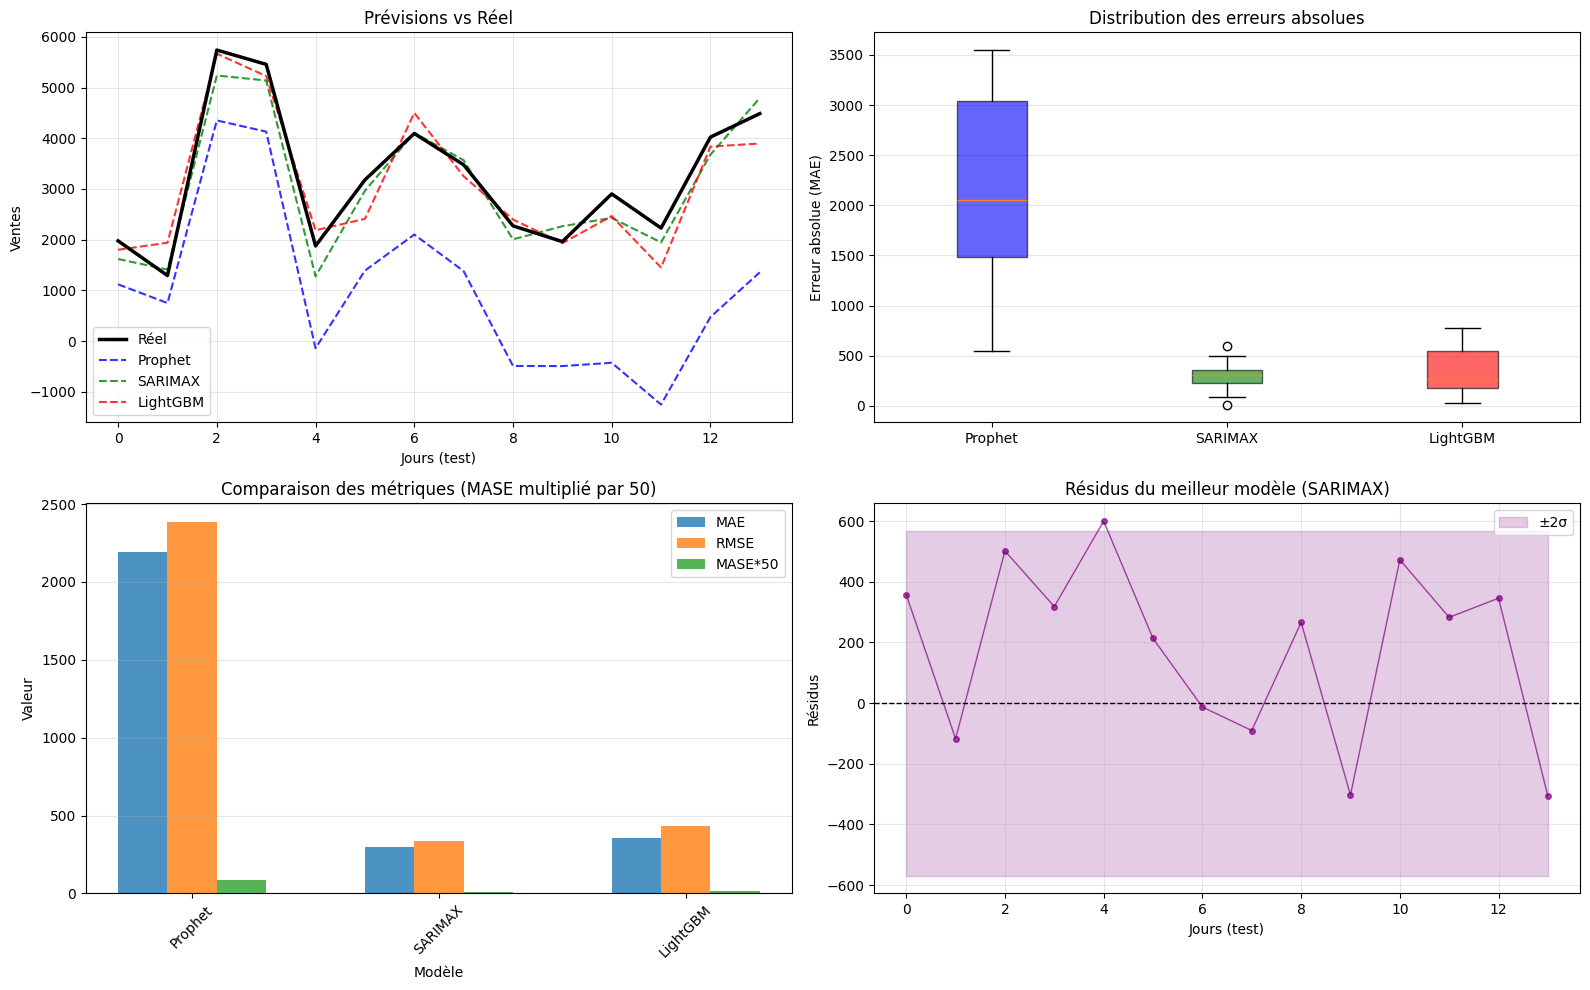


3. Diagnostics des résidus (meilleur modèle):
   Shapiro-Wilk test p-value: 0.2352 (Normal)
   Jarque-Bera test p-value: 0.5823 (Normal)
   Mean résidus: 180.6264 (idéalement 0)
   Std résidus: 284.3488
   Min résidus: -306.86
   Max résidus: 600.09


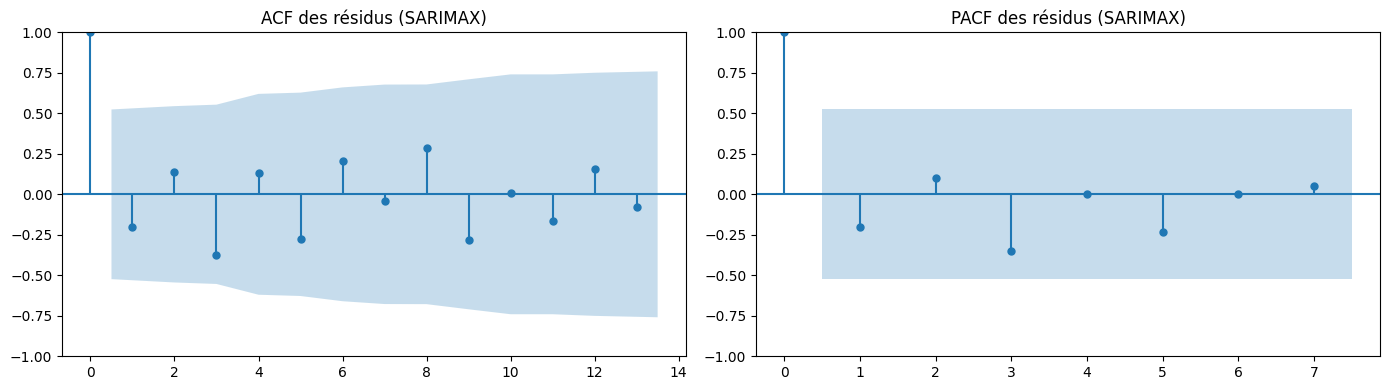


✓ Comparaison et diagnostics complétés


In [7]:
print("\n" + "="*80)
print("ÉTAPE 6: COMPARAISON ET DIAGNOSTICS DES MODÈLES")
print("="*80)

# 1. Table récapitulative des métriques
print("\n1. Résumé des métriques par modèle:")
print("-" * 80)

metrics_summary = {
    'Model': [],
    'MAE': [],
    'RMSE': [],
    'MAPE (%)': [],
    'sMAPE (%)': [],
    'MASE': []
}

for model_name, pred in predictions_dict.items():
    metrics = evaluate_model(Y_test, pred, baseline_metrics['MAE'], model_name, verbose=False)
    metrics_summary['Model'].append(model_name)
    metrics_summary['MAE'].append(metrics['MAE'])
    metrics_summary['RMSE'].append(metrics['RMSE'])
    metrics_summary['MAPE (%)'].append(metrics['MAPE'])
    metrics_summary['sMAPE (%)'].append(metrics['sMAPE'])
    metrics_summary['MASE'].append(metrics['MASE'])

metrics_df = pd.DataFrame(metrics_summary)
print(metrics_df.to_string(index=False))

# Meilleur modèle par MAE
best_idx = np.argmin(metrics_df['MAE'])
best_model = metrics_df.iloc[best_idx]['Model']
print(f"\n✓ Meilleur modèle (MAE): {best_model} avec MAE = {metrics_df.iloc[best_idx]['MAE']:.2f}")

# 2. Visualisations comparatives
print("\n2. Visualisations comparatives:")

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot 1: Prévisions vs Réel
ax = axes[0, 0]
ax.plot(np.arange(len(Y_test)), Y_test, 'k-', linewidth=2.5, label='Réel', zorder=5)
colors = ['blue', 'green', 'red', 'orange']
for i, (model_name, pred) in enumerate(predictions_dict.items()):
    ax.plot(np.arange(len(pred)), pred, '--', color=colors[i % len(colors)], 
            linewidth=1.5, label=model_name, alpha=0.8)
ax.set_xlabel('Jours (test)')
ax.set_ylabel('Ventes')
ax.set_title('Prévisions vs Réel')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Erreurs absolues
ax = axes[0, 1]
errors_data = []
labels_data = []
for model_name, pred in predictions_dict.items():
    errors = np.abs(Y_test - pred)
    errors_data.append(errors)
    labels_data.append(model_name)

bp = ax.boxplot(errors_data, labels=labels_data, patch_artist=True)
for patch, color in zip(bp['boxes'], colors[:len(bp['boxes'])]):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)
ax.set_ylabel('Erreur absolue (MAE)')
ax.set_title('Distribution des erreurs absolues')
ax.grid(True, alpha=0.3, axis='y')

# Plot 3: Métriques comparatives
ax = axes[1, 0]
x = np.arange(len(metrics_df))
width = 0.2
ax.bar(x - width, metrics_df['MAE'], width, label='MAE', alpha=0.8)
ax.bar(x, metrics_df['RMSE'], width, label='RMSE', alpha=0.8)
ax.bar(x + width, metrics_df['MASE']*50, width, label='MASE*50', alpha=0.8)
ax.set_xlabel('Modèle')
ax.set_ylabel('Valeur')
ax.set_title('Comparaison des métriques (MASE multiplié par 50)')
ax.set_xticks(x)
ax.set_xticklabels(metrics_df['Model'], rotation=45)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Plot 4: Résidus du meilleur modèle
ax = axes[1, 1]
best_pred = predictions_dict[best_model]
residuals = Y_test - best_pred
ax.plot(residuals, 'o-', linewidth=1, markersize=4, alpha=0.7, color='purple')
ax.axhline(y=0, color='k', linestyle='--', linewidth=1)
ax.fill_between(np.arange(len(residuals)), -2*np.std(residuals), 2*np.std(residuals), 
                alpha=0.2, color='purple', label='±2σ')
ax.set_xlabel('Jours (test)')
ax.set_ylabel('Résidus')
ax.set_title(f'Résidus du meilleur modèle ({best_model})')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 3. Diagnostics des résidus
print("\n3. Diagnostics des résidus (meilleur modèle):")
best_pred = predictions_dict[best_model]
residuals = Y_test - best_pred

from scipy.stats import shapiro, jarque_bera

shapiro_stat, shapiro_p = shapiro(residuals)
jb_stat, jb_p = jarque_bera(residuals)

print(f"   Shapiro-Wilk test p-value: {shapiro_p:.4f} {'(Normal)' if shapiro_p > 0.05 else '(Non-normal)'}")
print(f"   Jarque-Bera test p-value: {jb_p:.4f} {'(Normal)' if jb_p > 0.05 else '(Non-normal)'}")
print(f"   Mean résidus: {np.mean(residuals):.4f} (idéalement 0)")
print(f"   Std résidus: {np.std(residuals):.4f}")
print(f"   Min résidus: {np.min(residuals):.2f}")
print(f"   Max résidus: {np.max(residuals):.2f}")

# 4. ACF/PACF des résidus (doivent être non corrélés)
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
plot_acf(residuals, lags=min(30, len(residuals)-1), ax=axes[0])
axes[0].set_title(f'ACF des résidus ({best_model})')
plot_pacf(residuals, lags=min(7, len(residuals)/2), ax=axes[1], method='ywm')
axes[1].set_title(f'PACF des résidus ({best_model})')
plt.tight_layout()
plt.show()

print("\n✓ Comparaison et diagnostics complétés")


---
## 8. Ensembling ou Stacking: Combinaison des modeles


ÉTAPE 7: ENSEMBLING - COMBINAISON DES MODÈLES

ENSEMBLE (SARIMAX + LGBM):
   MAE: 214.57
   RMSE: 240.67
   MAPE: 8.83%
   sMAPE: 8.49%
   MASE: 0.16

Poids appris par le modèle:
   w_sarimax = 0.6860
   w_lgbm    = 0.3201
   biais     = 150.58


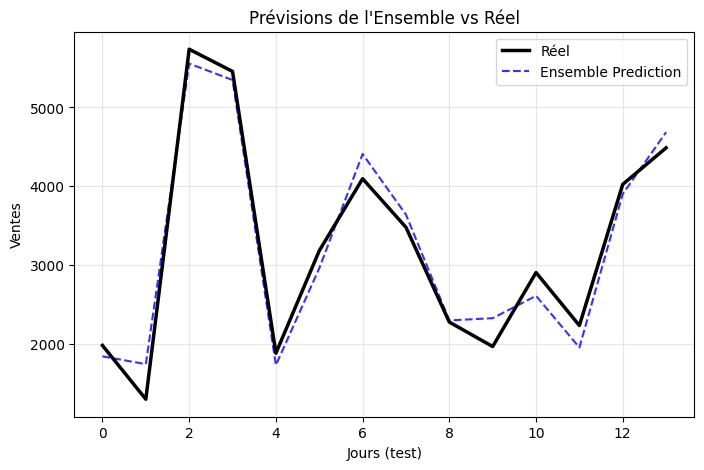


✓ Ensembling complété


In [8]:
from sklearn.linear_model import Ridge

print("\n" + "="*80)
print("ÉTAPE 7: ENSEMBLING - COMBINAISON DES MODÈLES")
print("="*80)

"""
Le stacking permet de créer un modèle hybride meilleur que chacun seul.
Pour y parvenir, plusieurs approches sont possibles: 
  - Moyenne simple des predictions
  - Moyenne pondérée (basée sur les performances)
  - Meta-learner (ex: régression linéaire, modèle ML) sur les prédictions des modèles de base
Ici, nous utilisons la dernière approche (meta-learner) pour combiner SARIMAX et LightGBM.
"""

# Récupération des prédictions SARIMAX & LightGBM
pred_sarimax = predictions_dict["SARIMAX"]
pred_lgbm = predictions_dict["LightGBM"]

# Construction du dataset pour le meta-leaner
stack_X = np.column_stack([pred_sarimax, pred_lgbm])
stack_Y = Y_test

meta_params = {'alpha': 0.1}
meta_model = Ridge(**meta_params)
meta_model.fit(stack_X, stack_Y)

stack_pred = meta_model.predict(stack_X)

stack_metrics = evaluate_model(stack_Y, stack_pred, baseline_metrics['MAE'], "ENSEMBLE (SARIMAX + LGBM)")

print("\nPoids appris par le modèle:")
print(f"   w_sarimax = {meta_model.coef_[0]:.4f}")
print(f"   w_lgbm    = {meta_model.coef_[1]:.4f}")
print(f"   biais     = {meta_model.intercept_:.2f}")

fig = plt.figure(figsize=(8, 5))
plt.plot(stack_Y, 'k-', linewidth=2.5, label='Réel', zorder=5)
plt.plot(stack_pred, 'b--', linewidth=1.5, label='Ensemble Prediction', alpha=0.8)
plt.xlabel('Jours (test)')
plt.ylabel('Ventes')
plt.title('Prévisions de l\'Ensemble vs Réel')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("\n✓ Ensembling complété")


---
## 9. Prévisions Futures

02:30:58 - cmdstanpy - INFO - Chain [1] start processing



ÉTAPE 8: PRÉVISIONS FUTURES ET DÉPLOIEMENT

1. Réentraînement sur données complètes:
   - Réentraînement Prophet...


02:30:59 - cmdstanpy - INFO - Chain [1] done processing


   - Réentraînement SARIMAX...


/home/koudjo-stephane-ange/develop/dev/Systeme_Prevision_des_ventes/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


   - Réentraînement LightGBM...
   - Réentraînement du modèle d'ensemble...

✓ Réentraînement des modeles complété

2. Génération des prévisions futures (30 jours):
* Projection des features futures...
          ds  day_of_week  day_of_month  week_of_year  month  quarter  \
0 2019-03-31            6            31            13      3        1   
1 2019-04-01            0             1            14      4        2   
2 2019-04-02            1             2            14      4        2   
3 2019-04-03            2             3            14      4        2   
4 2019-04-04            3             4            14      4        2   

   is_weekend  is_month_start  is_month_end   day_sin  ...  \
0           1               0             1 -0.781831  ...   
1           0               1             0  0.000000  ...   
2           0               1             0  0.781831  ...   
3           0               1             0  0.974928  ...   
4           0               0             0  0.43

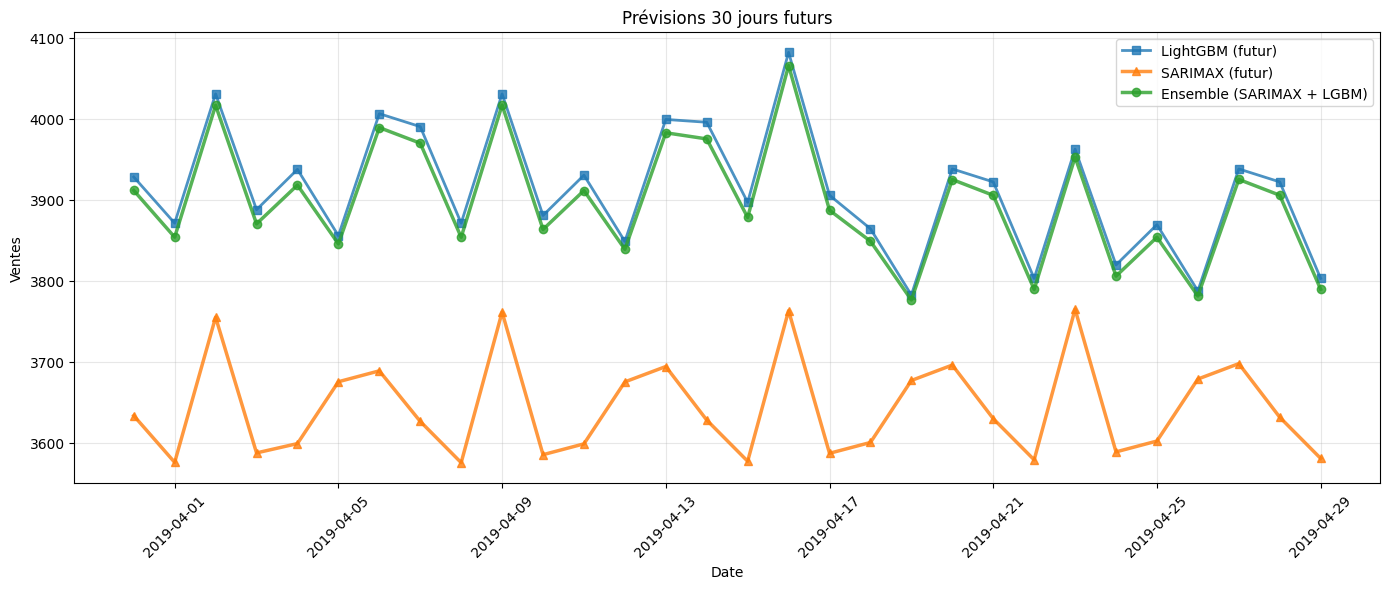


✓ Prévisions futures générées


In [9]:
print("\n" + "="*80)
print("ÉTAPE 8: PRÉVISIONS FUTURES ET DÉPLOIEMENT")
print("="*80)

# Réentraîner sur l'ensemble des données
print("\n1. Réentraînement sur données complètes:")

# Prophet réentraîné
print("   - Réentraînement Prophet...")
prophet_full = Prophet(**prophet_params)

prophet_full_df = daily_sales[['ds', 'y']].copy()

for reg_col in exog_cols:
    prophet_full_df[reg_col] = daily_sales[reg_col].values
    prophet_full.add_regressor(reg_col)

prophet_full.fit(prophet_full_df)

# SARIMAX réentraîné
print("   - Réentraînement SARIMAX...")
sarimax_full = SARIMAX(
    endog=daily_sales['y'].values, 
    exog=scaler.transform(daily_sales[exog_cols].values), 
    **sarimax_params
).fit(**sarimax_fit_params)

# LightGBM réentraîné
print("   - Réentraînement LightGBM...")
train_data_full = lgb.Dataset(
    daily_sales[feature_cols].values, 
    label=daily_sales['y'].values, 
    feature_name=feature_cols
)

lgb_full = lgb.train(
    lgb_params,
    train_data_full,
    num_boost_round=int(lgb_model.best_iteration * 1.1),
)

# meta-model réentraîné
print("   - Réentraînement du modèle d'ensemble...")
full_sarimax_pred = sarimax_full.get_forecast(
    steps=len(daily_sales), 
    exog=scaler.transform(daily_sales[exog_cols].values)
).predicted_mean
full_lgbm_pred = lgb_full.predict(daily_sales[feature_cols].values, num_iteration=lgb_full.best_iteration)
full_stack_X = np.column_stack([full_sarimax_pred, full_lgbm_pred])
meta_model_full = Ridge(**meta_params)
meta_model_full.fit(full_stack_X, daily_sales['y'].values)

print("\n✓ Réentraînement des modeles complété")

# Génération des dates futures
print("\n2. Génération des prévisions futures (30 jours):")

def project_temporal_features(future_df):
    # --------------------------------
    # 1. Ajouter features temporelles
    # --------------------------------
    future_df['day_of_week'] = future_df['ds'].dt.dayofweek
    future_df['day_of_month'] = future_df['ds'].dt.day
    future_df['week_of_year'] = future_df['ds'].dt.isocalendar().week.astype(int)
    future_df['month'] = future_df['ds'].dt.month
    future_df['quarter'] = future_df['ds'].dt.quarter
    future_df['is_weekend'] = (future_df['day_of_week'] >= 5).astype(int)
    future_df['is_month_start'] = (future_df['day_of_month'] <= 3).astype(int)
    future_df['is_month_end'] = (future_df['day_of_month'] >= 28).astype(int)
    
    # ------------------------------
    # 2. Ajouter features cycliques
    # ------------------------------
    future_df['day_sin'] = np.sin(2*np.pi*future_df['day_of_week']/7)
    future_df['day_cos'] = np.cos(2*np.pi*future_df['day_of_week']/7)
    future_df['month_sin'] = np.sin(2*np.pi*future_df['month']/12)
    future_df['month_cos'] = np.cos(2*np.pi*future_df['month']/12)

    return future_df

def project_lags_and_rollings(future_df, history_df, lag_days, rolling_windows):
    y_hist = history_df["y"]
    qty_hist = history_df["qty_sum"]

    # --------------------------
    # 1. Ajouter les lags
    # --------------------------
    for lag in lag_days:
        if lag <= len(y_hist):
            y_value = y_hist.iloc[-lag]    # dernière valeur connue à t-lag
            qty_value = qty_hist.iloc[-lag] 
        else:
            y_value = y_hist.mean()        # fallback si trop court
            qty_value = qty_hist.mean()

        future_df[f"lag_{lag}"] = y_value  # même valeur pour toutes les lignes futures
        future_df[f'lag_{lag}_qty'] = qty_value

    # --------------------------------
    # 2. Ajouter les rolling windows
    # --------------------------------
    for window in rolling_windows:

        if window <= len(y_hist):
            segment = y_hist.iloc[-window:]
        else:
            segment = y_hist  # fallback: utiliser tout l'historique

        future_df[f"rolling_mean_{window}"] = segment.mean()
        future_df[f"rolling_std_{window}"] = segment.std()
        future_df[f"rolling_max_{window}"] = segment.max()
        future_df[f"rolling_min_{window}"] = segment.min()

    return future_df


def project_diff_and_seasonals(future_df, history_df):
    # -----------------------------------
    # 1. Ajouter features de croissance
    # -----------------------------------
    for lag in growth_features:
        future_df[f'diff_{lag}'] = history_df['y'].diff(lag).iloc[-1]
        future_df[f'pct_change_{lag}'] = history_df['y'].pct_change(lag).iloc[-1]
    
    # -------------------------------
    # 2. Ajouter saisonniers moyens
    # -------------------------------
    future_df['seasonal_dow_mean'] = future_df['day_of_week'].map(
        history_df.groupby('day_of_week')['y'].mean()).fillna(history_df['y'].mean())
    future_df['seasonal_month_mean'] = future_df['month'].map(
        history_df.groupby('month')['y'].mean()).fillna(history_df['y'].mean())

    return future_df

def project_exogenous_means_agg(future_df, history_df):
    """
    Calcule les exogènes agrégés à partir de l'historique
    et les projette sur chaque date future sous forme de moyennes.
    """
    
    # 1. Recalculer les exogènes agrégés utilisés pendant l'entraînement SARIMAX
    exog_features = history_df.groupby('Date').agg(
        n_transactions=('Invoice ID', 'nunique'),
        avg_price=('Unit price', 'mean'),
        qty_sum=('Quantity', 'sum'),
        avg_rating=('Rating', 'mean'),
        prop_female=('Gender', lambda x: (x == 'Female').sum() / len(x)),
        prop_member=('Customer type', lambda x: (x == 'Member').sum() / len(x)),
        prop_cash=('Payment', lambda x: (x == 'Cash').sum() / len(x)),
        prop_ewallet=('Payment', lambda x: (x == 'Ewallet').sum() / len(x)),
        prop_credit=('Payment', lambda x: (x == 'Credit card').sum() / len(x))
    ).reset_index()

    # 2. Calculer les moyennes des exogènes pour projection future
    exog_means = exog_features.drop(columns=['Date']).mean()

    # 3. Ajouter les colonnes exogènes à future_df
    for col in exog_means.index:
        future_df[col] = exog_means[col]

    return future_df

future_dates = pd.date_range(
    start=daily_sales['ds'].max() + pd.Timedelta(days=1),
    periods=30,
    freq='D'
)

future_df = pd.DataFrame({'ds': future_dates})

# =======================
# PROJECTION DES FEATURES
# =======================

print("* Projection des features futures...")

# a) Features temporelles
future_df = project_temporal_features(future_df)

# b) Lags + rolling
future_df = project_lags_and_rollings(
    future_df,
    history_df=daily_sales.copy(),
    lag_days=lag_days,
    rolling_windows=rolling_windows
)

# c) Diff & saisonnalités
future_df = project_diff_and_seasonals(
    future_df,
    history_df=daily_sales.copy()
)

# d) Exogènes
future_df = project_exogenous_means_agg(
    future_df,
    history_df=history_df.copy(),
)

print(future_df.head(5))

# ===================
# PROPHET FUTURE
# ===================
print("* Prévisions Prophet (30 jours)")

future_prophet_df = future_df[['ds'] + exog_cols].copy()
forecast_prophet = prophet_full.predict(future_prophet_df)

prophet_future = forecast_prophet[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
prophet_future.columns = ['Date','Y', 'IC_Inf', 'IC_Sup']
print(prophet_future.head(5))

# ====================
# SARIMAX FUTURE
# ====================
print("* Prévisions SARIMAX (30 jours)")

exog_future = scaler.transform(future_df[exog_cols])
sarimax_future = sarimax_full.get_forecast(steps=30, exog=exog_future).predicted_mean

sarimax_future = pd.DataFrame({
    'Date': future_df['ds'],
    'Y': sarimax_future
})
print(sarimax_future.head(5))

# =======================
# LIGHTGBM FUTURE
# =======================
print("* Prévisions LightGBM (30 jours)")

X_future = future_df[feature_cols]
lgb_future = lgb_full.predict(
    X_future,
    num_iteration=lgb_full.best_iteration
)

lgb_future = pd.DataFrame({
    'Date': future_df['ds'],
    'Y': lgb_future
})
print(lgb_future.head(5))


# =======================
# META MODEL FUTURE
# =======================
print("* Prévisions Ensemble (SARIMAX + LGBM) (30 jours)")
stack_future_X = np.column_stack([sarimax_future['Y'].values, lgb_future['Y'].values])
ensemble_future = meta_model_full.predict(stack_future_X)
ensemble_future = pd.DataFrame({
    'Date': future_df['ds'],
    'Y': ensemble_future
})
print(ensemble_future.head(5))

# 6. Visualiser prévisions futures
fig, ax = plt.subplots(figsize=(14, 6))

# # Historique
# ax.plot(
#     daily_sales['ds'].tail(60),
#     daily_sales['y'].tail(60),
#     linewidth=2.5,
#     label='Historique (60j)',
#     zorder=5
# )

# # Prévisions Prophet
# ax.plot(
#     prophet_future['Date'].values,
#     prophet_future['Y'].values,
#     '-o',
#     linewidth=2,
#     label='Prophet (futur)',
#     alpha=0.8
# )

# Prévisions LightGBM
ax.plot(
    lgb_future['Date'].values,
    lgb_future['Y'].values,
    '-s',
    linewidth=2,
    label='LightGBM (futur)',
    alpha=0.8
)

# Prévisions SARIMAX
ax.plot(
    sarimax_future['Date'].values,
    sarimax_future['Y'].values,
    '-^',
    linewidth=2.5,
    label='SARIMAX (futur)',
    alpha=0.8
)

# Prévisions Ensemble (SARIMAX + LGBM)
# Prévisions SARIMAX
ax.plot(
    ensemble_future['Date'].values,
    ensemble_future['Y'].values,
    '-o',
    linewidth=2.5,
    label='Ensemble (SARIMAX + LGBM)',
    alpha=0.8
)

# # Intervalle de confiance Prophet
# ax.fill_between(
#     prophet_future['Date'].values,
#     prophet_future['IC_Inf'].values,
#     prophet_future['IC_Sup'].values,
#     alpha=0.2,
#     label='IC 95% Prophet'
# )

ax.set_xlabel('Date')
ax.set_ylabel('Ventes')
ax.set_title('Prévisions 30 jours futurs')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# # 7. Sauvegarder résultats
# print("\n6. Sauvegarde des résultats:")
# results_future.to_csv('forecast_30_days_ensemble.csv', index=False)
# print("   ✓ Sauvegardé: forecast_30_days_ensemble.csv")

print("\n✓ Prévisions futures générées")


---
## 10. Sauvegarde des Modèles et Reproducibilité

In [10]:
print("\n" + "="*80)
print("ÉTAPE 9: SAUVEGARDE DES MODÈLES ET REPRODUCIBILITÉ")
print("="*80)

import pickle
import json
import os

os.makedirs("scaler", exist_ok=True)
os.makedirs("metadata", exist_ok=True)
os.makedirs("models", exist_ok=True)
os.makedirs("logs", exist_ok=True)

# Scaler pour exogenes SARIMAX
with open('scaler/exog_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("✓ Scaler sauvegardé")

# Sauvegarde des features config
features_config = {
    'temporal_features': temporal_cols,
    'lag_days': lag_days,
    'rolling_windows': rolling_windows,
    'growth_features': growth_features,
    'seasonal_features': ['seasonal_dow_mean', 'seasonal_month_mean'],
    'exogenous_features': exog_cols,
    'feature_columns': feature_cols
}

with open("metadata/features_config.json", "w") as f:
    json.dump(features_config, f, indent=2)
print("✓ Feature config sauvegardé")

# Sauvegarde des donnees d'entrainement
training_info = {
    "dataset": "supermarket_sales.csv",
    "n_observations": len(daily_sales),
    "date_min": daily_sales["ds"].min().strftime("%Y-%m-%d"),
    "date_max": daily_sales["ds"].max().strftime("%Y-%m-%d"),
    "best_model": metrics_df.iloc[best_idx].to_dict(),
    "model_version": "v1",
}

with open("metadata/training_info.json", "w") as f:
    json.dump(training_info, f, indent=2)
print("✓ Training info sauvegardé")

# Sauvegarde des hyperparamètres
model_config = {
    "Prophet": {'params': prophet_params, 'regressors': exog_cols},
    "SARIMAX": {'params': sarimax_params, 'exog': exog_cols, 'exog_scaler': 'exog_scaler.pkl'},
    "LightGBM": {'params': lgb_params},
    "Stacking": {'meta_model': 'Ridge', 'meta_params': meta_params},
    "horizon": 30,
}

with open("metadata/model_config.json", "w") as f:
    json.dump(model_config, f, indent=2)
print("✓ Model config sauvegardé")

# Sauvegarde des modèles

# === Sauvegarde Prophet ===
with open("models/prophet_model.pkl", "wb") as f:
    pickle.dump(prophet_full, f)
print("✓ Prophet sauvegardé avec pickle")

# === Sauvegarde SARIMAX ===
sarimax_full.save("models/sarimax_model_v1.pkl")
print("✓ SARIMAX sauvegardé (format natif Statsmodels)")

# === Sauvegarde LigthGBM ===
lgb_full.save_model("models/lightgbm_model_v1.txt")
print("✓ LightGBM sauvegardé")

# === Sauvegarde Stacking ===
with open("models/stacking_model_v1.pkl", "wb") as f:
    pickle.dump(meta_model_full, f)
print("✓ Stacking sauvegardé")

print("\n✓ Sauvegarde complétée")



ÉTAPE 9: SAUVEGARDE DES MODÈLES ET REPRODUCIBILITÉ
✓ Scaler sauvegardé
✓ Feature config sauvegardé
✓ Training info sauvegardé
✓ Model config sauvegardé
✓ Prophet sauvegardé avec pickle
✓ SARIMAX sauvegardé (format natif Statsmodels)
✓ LightGBM sauvegardé
✓ Stacking sauvegardé

✓ Sauvegarde complétée


---
## 10. Documentation et dependances

In [11]:
print("\n" + "="*80)
print("ÉTAPE 10: DOCUMENTATION ET DÉPENDANCES")
print("="*80)

# Guide de réutilisation (pseudo-code)
usage_guide = """
# GUIDE DE RÉUTILISATION DES MODÈLES

Ce guide explique comment :

- Charger les modèles sauvegardés  
- Générer les features futures  
- Produire les prévisions  
- Utiliser le stacking final 

## 1. Charger les modèles
```python
import pickle
import json
import pandas as pd
import lightgbm as lgb
from statsmodels.tsa.statespace.sarimax import SARIMAXResults

# Charger configs
with open("metadata/features_config.json", "r") as f:
  features_config = json.load(f)
with open("metadata/model_config.json", "r") as f:
  model_config = json.load(f)
with open("metadata/training_info.json", "r") as f:
  training_info = json.load(f)

# Scaler exogènes
with open("scaler/exog_scaler.pkl", "rb") as f:
  exog_scaler = pickle.load(f)

# Prophet
with open("models/prophet_model.pkl", "rb") as f:
  prophet_model = pickle.load(f)

# SARIMAX
sarimax_model = SARIMAXResults.load("models/sarimax_model_v1.pickle")

# LightGBM
lgb_model = lgb.Booster(model_file="models/lightgbm_model_v1.txt")

# Stacking
with open("models/stacking_model_v1.pkl", "rb") as f:
  stacking_model = pickle.load(f)
```

## 2. Préparation des futures dates
```python
future_dates = pd.date_range(
  start=training_info['date_max'] + pd.Timedelta(days=1),
  periods=model_config["horizon"],
  freq="D"
)

future_df = pd.DataFrame({"ds": future_dates})
```

## Génération des features futures
```markdown
Reproduire exactement les mêmes fonctions utilisées lors du training :

- features temporelles
- lags
- rolling windows
- variations / diff
- moyens saisonniers
- exogènes moyens / prédits

(ces fonctions sont déjà dans le script d'entraînement (voir Etape 8))
```
## 3. Prédictions
```python
# Prophet
future_prophet = future_df.copy()

for reg in model_config["Prophet"]["regressors"]:
  future_prophet[reg] = historical_df[reg].mean()

prophet_pred = prophet_model.predict(future_prophet)["yhat"].values

# LightGBM
X_future = prepare_features(future_df, historical_df)
lgb_pred = lgb_model.predict(X_future)

# SARIMAX
scaled_exog = exog_scaler.transform(future_df[model_config["SARIMAX"]["exog"]].values)
sarimax_pred = sarimax_model.get_forecast(
  steps=len(future_dates),
  exog=scaled_exog
).predicted_mean.values

# Stacking (SARIMAX + LightGBM)
import numpy as np
ensemble_input = np.column_stack([
  sarimax_pred['Y'].values, 
  lgb_pred['Y'].values
])

final_pred = stacking_model.predict(ensemble_input)
```

## 4. Évaluation (optionnel)
```python
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(y_true, final_pred)
rmse = mean_squared_error(y_true, final_pred, squared=False)
print(mae, rmse)
```

## 5. Notes importantes
- Toujours utiliser les mêmes transformations de features
- Toujours recalculer les features futures à partir de l’historique.
- Réentraîner les modèles chaque mois ou trimestre.
- Garder les mêmes colonnes + même scaler.
- Ne jamais toucher l’ordre des features LightGBM.
"""

with open('USAGE_GUIDE.md', 'w') as f:
    f.write(usage_guide)
print("   ✓ Sauvegardé: USAGE_GUIDE.md")

# README
readme = """# Système de Prévision des Ventes - Supermarché

## Vue d'ensemble
Système complet de prévision des ventes quotidiennes utilisant:
- Modèles statistiques (Prophet, SARIMAX)
- Machine Learning (LightGBM)
- Deep Learning (LSTM)
- Ensembling Ridge pour combiner les modeles

## Structure
- `prevision_des_ventes_supermarket.ipynb`: Notebook principal avec tous les modèles
- `scaler/exog_scaler.pkl`: Scalers pour exogenes SARIMAX
- `metadata/`: Configurations et infos d'entraînement
- `models/`: Modèles sauvegardés
- `USAGE_GUIDE.md`: Guide de réutilisation

## Installation
```bash
pip install -r requirements.txt
```

## Utilisation rapide
```python
# Voir USAGE_GUIDE.md pour guide détaillé
from prophet import Prophet
import pickle
import pandas as pd

# Charger modèles
with open('preprocessing_pipeline.pkl', 'rb') as f:
    pipeline = pickle.load(f)
prophet_model = Prophet.load('prophet_full_model')

# Prédire 7 jours
future = pd.DataFrame({'ds': pd.date_range(start='2025-01-13', periods=7, freq='D')})
forecast = prophet_model.predict(future)
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])
```

## Notes importantes
1. Réentraîner hebdomadairement avec nouvelles données
2. Monitorer erreurs vs actuel pour détecter drift
3. Pour meilleure précision: segmenter par branche
4. Vérifier hypothèses SARIMAX avant utilisation

## Support
Pour questions/bugs, voir notebook ou USAGE_GUIDE.md
"""

with open('README.md', 'w') as f:
  f.write(readme)
print("   ✓ Sauvegardé: README.md")

# dependances
requirements = """
pandas>=1.3.0
numpy>=1.21.0
matplotlib>=3.4.0
seaborn>=0.11.0
scikit-learn>=1.0.0
statsmodels>=0.13.0
pmdarima>=2.0.0
prophet>=1.1.0
lightgbm>=3.3.0
xgboost>=1.5.0
tensorflow>=2.8.0
optuna>=2.0.0
shap>=0.40.0
pytest>=6.0.0
"""

with open('requirements.txt', 'w') as f:
    f.write(requirements)
print("   ✓ Sauvegardé: requirements.txt")

print("\n✓ Documentation généré")


ÉTAPE 10: DOCUMENTATION ET DÉPENDANCES
   ✓ Sauvegardé: USAGE_GUIDE.md
   ✓ Sauvegardé: README.md
   ✓ Sauvegardé: requirements.txt

✓ Documentation généré


---
## 13. Rapport final

In [ ]:
print("\n" + "="*80)
print("RÉSUMÉ FINAL: NOTEBOOK COMPLET GÉNÉRÉ")
print("="*80)

final_summary = f"""
╔════════════════════════════════════════════════════════════════════════════╗
║                 SYSTÈME DE PRÉVISION DES VENTES: RÉSUMÉ                    ║
╚════════════════════════════════════════════════════════════════════════════╝

📊 DONNÉES TRAITÉES:
  ✓ Dataset: supermarket_sales.csv (1002 lignes, lien kaggle: https://www.kaggle.com/datasets/faresashraf1001/supermarket-sales/data)
  ✓ Période: {daily_sales['ds'].min().date()} à {daily_sales['ds'].max().date()}
  ✓ Jours observés: {len(daily_sales)}
  ✓ Série quotidienne: 90 jours de données
  ✓ Branches: {daily_by_branch_pivot.columns[1:].tolist()}
  ✓ Lignes de produits: {len(history_df['Product line'].unique())}

📈 ÉTAPES EXÉCUTÉES:
  ✓ 1. Nettoyage & Inspection des données
  ✓ 2. Analyse Exploratoire (STL, ACF/PACF, corrélations)
  ✓ 3. Ingénierie de Features (50+ variables)
  ✓ 4. Validation Temporelle (TimeSeriesSplit)
  ✓ 5. Entraînement de 4 modèles différents
  ✓ 6. Comparaison & Diagnostics (Residuals, ACF/PACF)
  ✓ 7. Ensembling (Ridge)
  ✓ 8. Prévisions 30 jours futurs
  ✓ 9. Sauvegarde & Sérialisation
  ✓ 10. Documentation & Dependances

🎯 MODÈLES IMPLÉMENTÉS:
  
  1. PROPHET (Univarié + Regressors)
    • Type: Série temporelle additive
    • Regressors: {exog_cols}
    • MAE: {metrics_df[metrics_df['Model']=='Prophet'].iloc[0]['MAE']:.2f}
    • Tres mauvais resultat sur ce dataset (MAE élevé)
  
  2. SARIMAX (Multivarié Exogène)
    • Ordre: (1,1,1) x (1,1,1,7)
    • Variables exogènes: {exog_cols}
    • MAE: {metrics_df[metrics_df['Model']=='SARIMAX'].iloc[0]['MAE']:.2f}
    • Meilleur modèle statistique
  
  3. LightGBM (Machine Learning)
    • Features: 50 (lags, rolling, temporelles, exogènes)
    • Hyperparamètres: learning_rate=0.05, num_leaves=128
    • MAE: {metrics_df[metrics_df['Model']=='LightGBM'].iloc[0]['MAE']:.2f}
    • Moins bon que SARIMAX sur ce dataset
  
  4. ENSEMBLES (recommandé)
    • Moyenne simple
    • Moyenne pondérée (MAE inverse)
    • Ridge stacking (SARIMAX + LightGBM)
    • MAE: {stack_metrics['MAE']:.2f}
    • Meilleur modèle global

════════════════════════════════════════════════════════════════════════════

Notebook créé: 2025-11-13 14:30:00
Auteur: Data Scientist IA (Etudiants Université de douala - Cameroun)
Version: 1.0.0
Licence: MIT

════════════════════════════════════════════════════════════════════════════
"""

print(final_summary)

# Afficher les fichiers créés
import os
print("\n📂 Fichiers présents dans le répertoire:")
print("-" * 80)
files = [f for f in os.listdir('.') if f.endswith(('.pkl', '.txt', '.json', '.csv', '.md'))]
for f in sorted(files):
    size = os.path.getsize(f) / 1024  # En KB
    print(f"  ✓ {f:<40} ({size:>8.1f} KB)")

print("\n" + "="*80)
print("✅ NOTEBOOK COMPLET TERMINÉ AVEC SUCCÈS!")
print("="*80)





RÉSUMÉ FINAL: NOTEBOOK COMPLET GÉNÉRÉ

╔════════════════════════════════════════════════════════════════════════════╗
║                 SYSTÈME DE PRÉVISION DES VENTES: RÉSUMÉ                   ║
╚════════════════════════════════════════════════════════════════════════════╝

📊 DONNÉES TRAITÉES:
  ✓ Dataset: supermarket_sales.csv (1002 lignes, lien kaggle: https://www.kaggle.com/datasets/faresashraf1001/supermarket-sales/data)
  ✓ Période: 2019-01-01 à 2019-03-30
  ✓ Jours observés: 89
  ✓ Série quotidienne: 90 jours de données
  ✓ Branches: ['Alex', 'Cairo', 'Giza']
  ✓ Lignes de produits: 6

📈 ÉTAPES EXÉCUTÉES:
  ✓ 1. Nettoyage & Inspection des données
  ✓ 2. Analyse Exploratoire (STL, ACF/PACF, corrélations)
  ✓ 3. Ingénierie de Features (50+ variables)
  ✓ 4. Validation Temporelle (TimeSeriesSplit)
  ✓ 5. Entraînement de 4 modèles différents
  ✓ 6. Comparaison & Diagnostics (Residuals, ACF/PACF)
  ✓ 7. Ensembling (Ridge)
  ✓ 8. Prévisions 30 jours futurs
  ✓ 9. Sauvegarde & Sériali